### Importing Modules 

In [288]:
%reset -f

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import os.path
import os
import pickle
from scipy.ndimage.interpolation import shift
import scipy.stats as stats

from intanRead import IntanRaw_read_data

from tkinter import Tk
from tkinter.filedialog import askopenfilename

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
from scipy.signal import butter, filtfilt, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

## Getting the data file 

In [3]:
defaultDataDir = "C:\\Users\Student\Desktop\RHD2000interface_compiled_v1_5_2"

if not os.path.isdir(defaultDataDir):
    defaultDataDir = "C:\\"
    
root = Tk()
root.withdraw()

dataFileAdd =  askopenfilename(initialdir = defaultDataDir,title = "Select file",\
                            filetypes = (("Intan raw files","*.rhd"),("all files","*.*")))

dataFileName = os.path.basename(dataFileAdd)[:-4]
dataFileBaseFolder = os.path.dirname(dataFileAdd)

## Reading the data file

In [4]:
readResult = IntanRaw_read_data.IntanRaw_read_data(dataFileAdd)


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 0 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 3 board ADC channels.
Found 3 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 15.624 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.3 seconds


### Info about this Screen Test data

In [6]:
photoDiodeSig = deepcopy(readResult['board_adc_data'][0])
beforeStimFlipTag = deepcopy(readResult['board_dig_in_data'][0]).astype('int')
afterStimFlipTag = deepcopy(readResult['board_dig_in_data'][1]).astype('int')


Fs = readResult['frequency_parameters']['board_dig_in_sample_rate']

### Digital Tags

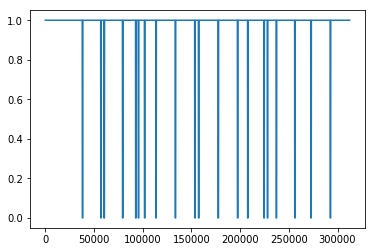

In [7]:
plt.plot(afterStimFlipTag)

### falling and rising edges of the digital tags

In [8]:
downTransitionBeforeStimFlipTag = np.where ((beforeStimFlipTag[1:] == 0)  & (np.diff(beforeStimFlipTag)<0))[0]

downTransitionAfterStimFlipTag = np.where ((afterStimFlipTag[1:] == 0)  & (np.diff(afterStimFlipTag)<0))[0]

upTransitionAfterStimEndFlipTag = np.where ((afterStimFlipTag[:-1] == 0)  & (np.diff(afterStimFlipTag)>0))[0] +1


# print(upTransitionDigSignal0.shape,downTransitionDigSignal0.shape)

In [10]:
(downTransitionAfterStimFlipTag - downTransitionBeforeStimFlipTag)*1e3/Fs

array([5.65, 8.9 , 9.15, 6.4 , 8.9 , 4.8 , 9.1 , 7.55, 7.8 , 6.25, 8.  ,
       6.05, 8.4 , 7.9 , 4.55, 6.75, 5.75, 5.35, 6.35, 6.05])

### mean of stimulus duration based on the digital tag

In [11]:
print(np.mean((upTransitionAfterStimEndFlipTag - downTransitionAfterStimFlipTag)[:]*1e3/Fs))
print(np.std((upTransitionAfterStimEndFlipTag - downTransitionAfterStimFlipTag)*1e3/Fs))

27.712499999999995
0.334990671511909


### Photo-Diode Signal

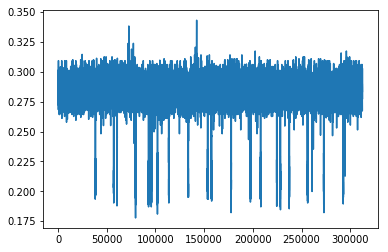

In [12]:
plt.plot(photoDiodeSig)

## filtering the diode signal

In [13]:
filteredPhotoDiodeSig = butter_lowpass_filter(photoDiodeSig, 1000, Fs, order=5)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


one frame Duration in ms: 5.555555555555555
Expected Stimulus Duration in ms: 27.77777777777778
Estimated Stimulus Duration from photoDiode: [27.2  27.25 27.25 27.15 27.2  27.2  27.05 27.1  27.25 27.35 27.25 27.35
 27.25 27.1  27.25 27.2  27.3  27.25 27.1  27.25]


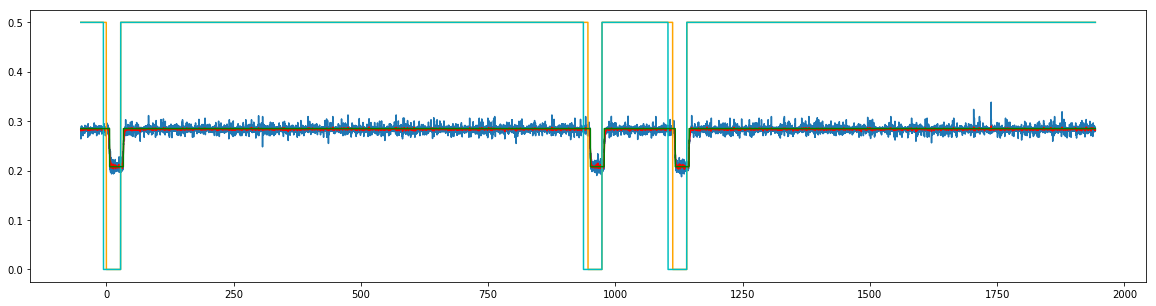

In [15]:
refR = 180
frameNumber = 5

plt.figure(figsize=(20,5))

downTransitToLook = 0
windowToLook = 38860
windowToLookBack = 1000

plt.plot(np.arange(-windowToLookBack,windowToLook)*1e3/Fs,photoDiodeSig\
                 [downTransitionAfterStimFlipTag[downTransitToLook]-windowToLookBack:\
                       downTransitionAfterStimFlipTag[downTransitToLook]+windowToLook])

plt.plot(np.arange(-windowToLookBack,windowToLook)*1e3/Fs,filteredPhotoDiodeSig\
                 [downTransitionAfterStimFlipTag[downTransitToLook]-windowToLookBack:\
                       downTransitionAfterStimFlipTag[downTransitToLook]+windowToLook],'r')

plt.plot(np.arange(-windowToLookBack,windowToLook)*1e3/Fs,0.5*afterStimFlipTag\
                 [downTransitionAfterStimFlipTag[downTransitToLook]-windowToLookBack:\
                          downTransitionAfterStimFlipTag[downTransitToLook]+windowToLook],'orange')

plt.plot(np.arange(-windowToLookBack,windowToLook)*1e3/Fs,0.5*beforeStimFlipTag\
                 [downTransitionAfterStimFlipTag[downTransitToLook]-windowToLookBack:\
                          downTransitionAfterStimFlipTag[downTransitToLook]+windowToLook],'c')

# frameDurMiliSec = 1*1e3/refR
# shiftedTag = shift(digitalSync0, int(frameDurMiliSec*Fs/1e3), cval=max(digitalSync0))
# plt.plot(np.arange(-windowToLookBack,windowToLook)*1e3/Fs,0.5*shiftedTag[downTransitionDigSignal0[downTransitToLook]-windowToLookBack:\
#                           downTransitionDigSignal0[downTransitToLook]+windowToLook],'c')

cutLine = 0.24 #(highLevelAvg + lowLevelAvg)/2

lowLevelAvg = 0.208
highLevelAvg = 0.285

digitizedFilteredSig = deepcopy(filteredPhotoDiodeSig)
digitizedFilteredSig[digitizedFilteredSig<cutLine] = lowLevelAvg
digitizedFilteredSig[digitizedFilteredSig>cutLine] = highLevelAvg

plt.plot(np.arange(-windowToLookBack,windowToLook)*1e3/Fs,digitizedFilteredSig\
                 [downTransitionAfterStimFlipTag[downTransitToLook]-windowToLookBack:\
                       downTransitionAfterStimFlipTag[downTransitToLook]+windowToLook],'g')

stimOnset = np.where ((digitizedFilteredSig[1:] == min(digitizedFilteredSig))  & (np.diff(digitizedFilteredSig)<0))[0]
stimOf = np.where ((digitizedFilteredSig[:-1] == min(digitizedFilteredSig))  & (np.diff(digitizedFilteredSig)>0))[0] +1

stimDurDigitizedPhotoDiodeSig = (stimOf - stimOnset)*1e3/Fs



print ('one frame Duration in ms:', 1.0e3/refR)
print ('Expected Stimulus Duration in ms:', frameNumber*1.0e3/refR)
print ('Estimated Stimulus Duration from photoDiode:', stimDurDigitizedPhotoDiodeSig)


### the falling edge of the photodiode signal (blue/rad --> raw/filtered voltage) is defined as the stim onset, the stimulus is presented while the voltage level is low (area underneath the photoiode is "black"). Before and after the Flip for stimulus two digital tags are sent (falling edge of the cyan/orange signals -- d8-9 of intan here). Just after the default frame (white screen) at the end of the stimulus is sent to the screen, the digital tags go to the default high value.
### Stimulus duration (5 frames in this example) is acheived with less than 1ms error! (FANTASTIC)
### As it is seen, in this setup (Dell percision 4320, onboard graphic card and the Asus screen), the stimulus starts in the next frame after the Flip command (with delays less than 10 ms) reliably! And because of the sharp change of the photodiode signal (good response time of the screen) we get a good and reliable estimation of the stimulus start time.
### This is measured with the photodiode we borrowed from Luke
### Beampose estimation works on this setup
### Important Notes: in case of using Nvidia graphic card g-sync MUST be disabled 

### Digitization of the photo-diode signal and the definition of the stimulus onset

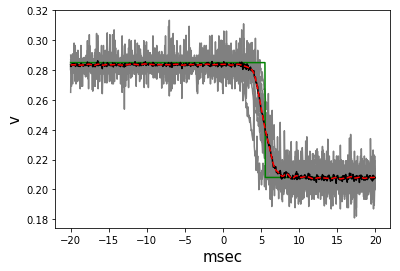

In [16]:
transWindowToLook = 20
meanAroundafterStimFlipTag = 0
meanFilteredAroundafterStimFlipTag = 0

# correctedDigitalTag = downTransitionDigSignal0+int(frameDurMiliSec*Fs/1e3) #Correction for the one frame delay

for tagTime in downTransitionAfterStimFlipTag: 
#     plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            photoDiodeSig[int(tagTime-transWindowToLook*Fs/1e3):\
                       int(tagTime+transWindowToLook*Fs/1e3)],'gray')
    
    meanAroundafterStimFlipTag += photoDiodeSig[int(tagTime-transWindowToLook*Fs/1e3):\
                       int(tagTime+transWindowToLook*Fs/1e3)]
    
    meanFilteredAroundafterStimFlipTag += filteredPhotoDiodeSig[int(tagTime-transWindowToLook*Fs/1e3):\
                       int(tagTime+transWindowToLook*Fs/1e3)]
    
meanAroundafterStimFlipTag = meanAroundafterStimFlipTag/len(downTransitionAfterStimFlipTag)
meanFilteredAroundafterStimFlipTag = meanFilteredAroundafterStimFlipTag/len(downTransitionAfterStimFlipTag)

# lowLevelAvg = np.mean(meanFilteredAroundTagCorrected[int((transWindowToLook + 5) *Fs/1e3):int((transWindowToLook + 10) *Fs/1e3)])
# highLevelAvg = np.mean(meanFilteredAroundTagCorrected[int((transWindowToLook - 10) *Fs/1e3):int((transWindowToLook - 5) *Fs/1e3)])

# cutLine = 0.24 #(highLevelAvg + lowLevelAvg)/2

# digitizedFilteredSig = deepcopy(filteredPhotoDiodeSig)
# digitizedFilteredSig[digitizedFilteredSig<cutLine] = lowLevelAvg
# digitizedFilteredSig[digitizedFilteredSig>cutLine] = highLevelAvg

digitizedAvg = deepcopy(meanFilteredAroundafterStimFlipTag)
digitizedAvg[meanFilteredAroundafterStimFlipTag<cutLine] = lowLevelAvg
digitizedAvg[meanFilteredAroundafterStimFlipTag>cutLine] = highLevelAvg
    
plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),digitizedAvg,'g')
plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),meanAroundafterStimFlipTag,'k')
plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),meanFilteredAroundafterStimFlipTag,'r--')

plt.xlabel('msec',fontsize=15);
plt.ylabel('v',fontsize=15);

### Manual boundries of the photodiode falling edge

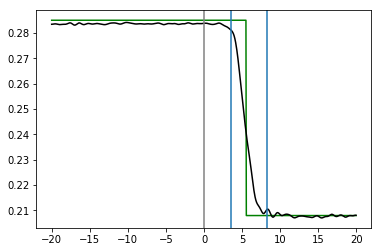

In [17]:
plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),digitizedAvg,'g')
plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),meanFilteredAroundafterStimFlipTag,'k')

plt.axvline(0,c='gray')
plt.axvline(3.6)
plt.axvline(8.2)

## Stimulus Onset Calculation

In [18]:
stimOnset = np.where ((digitizedFilteredSig[1:] == min(digitizedFilteredSig))  & (np.diff(digitizedFilteredSig)<0))[0]
stimOf = np.where ((digitizedFilteredSig[:-1] == min(digitizedFilteredSig))  & (np.diff(digitizedFilteredSig)>0))[0] +1

In [19]:
(stimOnset - downTransitionAfterStimFlipTag)*1e3/Fs

array([6.4 , 4.8 , 5.05, 5.05, 3.75, 5.65, 6.  , 5.55, 5.8 , 5.5 , 5.45,
       5.5 , 5.55, 5.8 , 6.  , 5.65, 5.75, 5.55, 5.75, 5.65])

In [20]:
max((stimOnset - downTransitionAfterStimFlipTag)*1e3/Fs)

6.4

In [21]:
print(np.mean((stimOnset - downTransitionAfterStimFlipTag)*1e3/Fs))
print(np.std((stimOnset - downTransitionAfterStimFlipTag)*1e3/Fs))

5.51
0.531413210223457


In [22]:
(stimOnset - downTransitionBeforeStimFlipTag)*1e3/Fs

array([12.05, 13.7 , 14.2 , 11.45, 12.65, 10.45, 15.1 , 13.1 , 13.6 ,
       11.75, 13.45, 11.55, 13.95, 13.7 , 10.55, 12.4 , 11.5 , 10.9 ,
       12.1 , 11.7 ])

In [23]:
print(np.mean((stimOnset - downTransitionBeforeStimFlipTag)*1e3/Fs))
print(np.std((stimOnset - downTransitionBeforeStimFlipTag)*1e3/Fs))

12.4925
1.2702632601157917


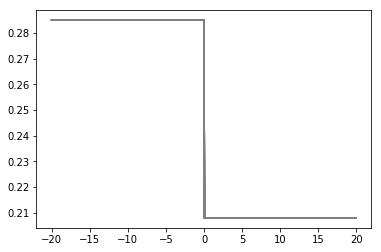

In [24]:
transWindowToLook = 20
for stimTime in stimOnset:
#     plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            digitizedFilteredSig[int(stimTime-transWindowToLook*Fs/1e3):\
                       int(stimTime+transWindowToLook*Fs/1e3)],'gray')

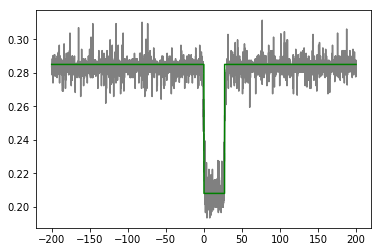

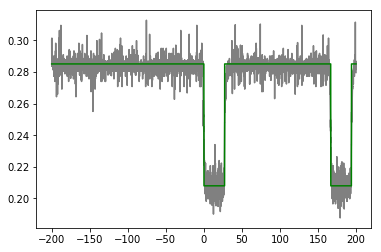

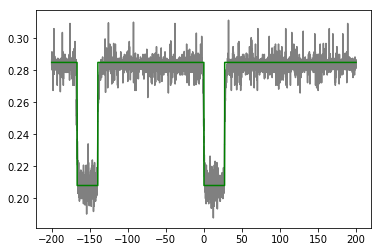

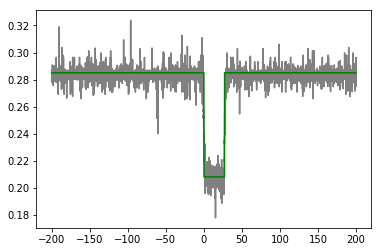

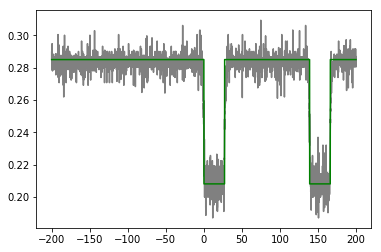

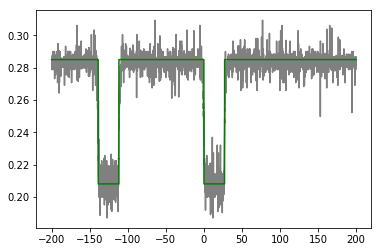

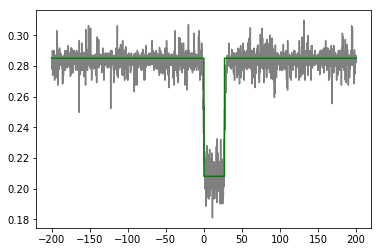

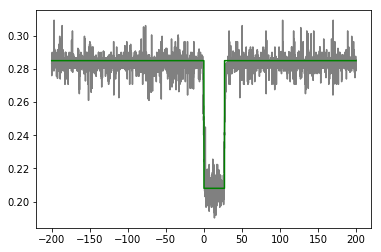

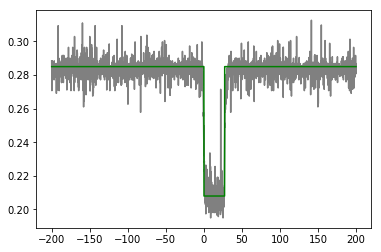

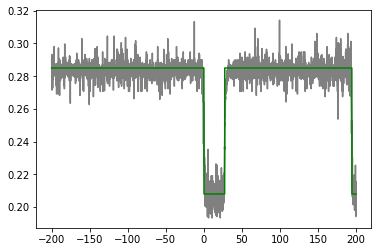

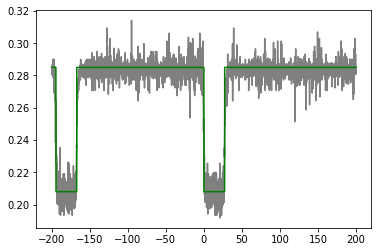

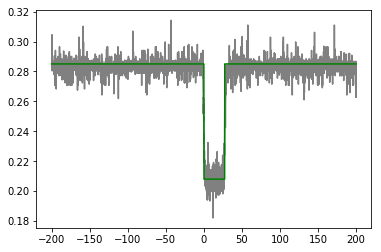

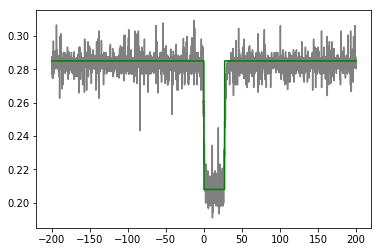

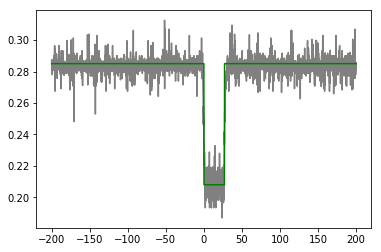

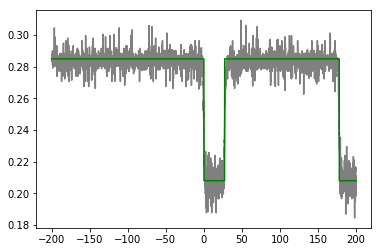

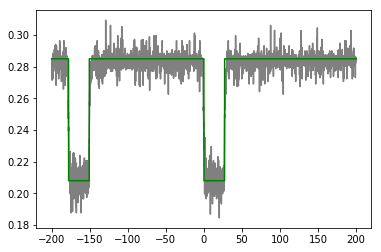

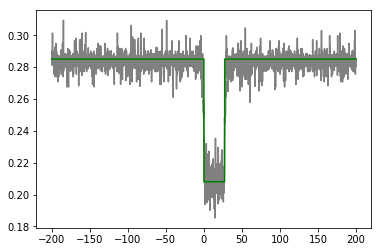

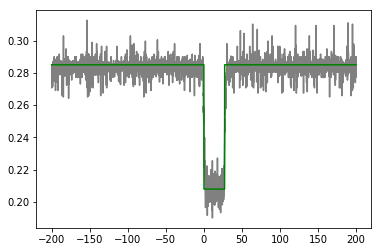

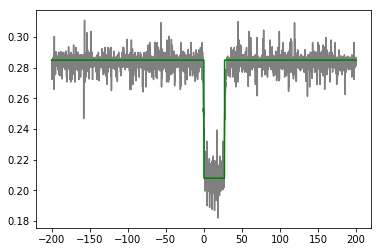

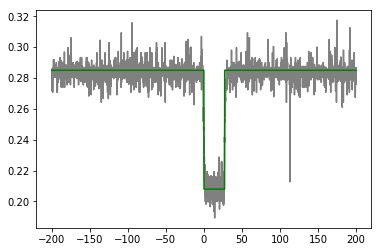

In [25]:
transWindowToLook = 200
for stimTime in stimOnset:
    plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            photoDiodeSig[int(stimTime-transWindowToLook*Fs/1e3):\
                       int(stimTime+transWindowToLook*Fs/1e3)],'gray')
    
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            digitizedFilteredSig[int(stimTime-transWindowToLook*Fs/1e3):\
                       int(stimTime+transWindowToLook*Fs/1e3)],'g')

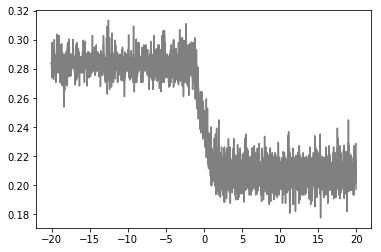

In [26]:
transWindowToLook = 20
for stimTime in stimOnset:
#     plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            photoDiodeSig[int(stimTime-transWindowToLook*Fs/1e3):\
                       int(stimTime+transWindowToLook*Fs/1e3)],'gray')

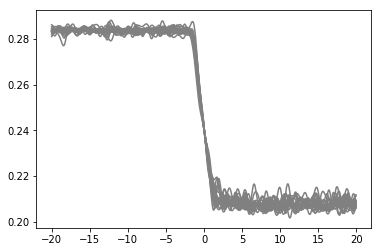

In [27]:
transWindowToLook = 20
for stimTime in stimOnset:
#     plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            filteredPhotoDiodeSig[int(stimTime-transWindowToLook*Fs/1e3):\
                       int(stimTime+transWindowToLook*Fs/1e3)],'gray')

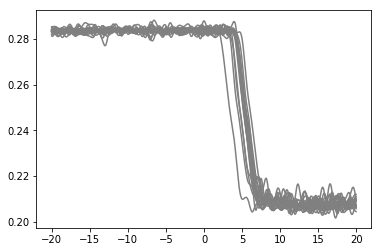

In [28]:
transWindowToLook = 20
for tagTimeCorrected in downTransitionAfterStimFlipTag:
#     plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            filteredPhotoDiodeSig[int(tagTimeCorrected-transWindowToLook*Fs/1e3):\
                       int(tagTimeCorrected+transWindowToLook*Fs/1e3)],'gray')

## Stimulus Duration based on the low-voltage duration in the digitized photodiode signal and based on the zero time of the digital tag

In [29]:
print('Ideal Stimulus Duration:', frameNumber*1.0e3/refR)

Ideal Stimulus Duration: 27.77777777777778


In [30]:
stimDurDigitalTag = (upTransitionAfterStimEndFlipTag - downTransitionAfterStimFlipTag)*1e3/Fs
stimDurDigitizedPhotoDiodeSig = (stimOf - stimOnset)*1e3/Fs

In [31]:
stimDurDigitalTag

array([28.2 , 27.55, 27.7 , 27.75, 27.9 , 27.65, 27.9 , 27.75, 27.9 ,
       27.65, 27.7 , 27.75, 27.65, 26.85, 28.15, 26.8 , 27.95, 27.8 ,
       27.85, 27.8 ])

In [32]:
stimDurDigitizedPhotoDiodeSig

array([27.2 , 27.25, 27.25, 27.15, 27.2 , 27.2 , 27.05, 27.1 , 27.25,
       27.35, 27.25, 27.35, 27.25, 27.1 , 27.25, 27.2 , 27.3 , 27.25,
       27.1 , 27.25])

In [33]:
stats.pearsonr(stimDurDigitalTag,stimDurDigitizedPhotoDiodeSig)

(0.16251353215741574, 0.4936227472706295)

In [34]:
print(np.mean(stimDurDigitizedPhotoDiodeSig))
print(np.std(stimDurDigitizedPhotoDiodeSig))

27.214999999999996
0.07921489758877429


## Try to compensate the delay between the tag time and the stimulus onset based on the PTB and Matlab outputs

In [35]:
estimatedTagDelay = [0.00474570332835356,\
0.00623950332692402,\
0.00680236666357814,\
0.00398806514886019,\
0.00500148109676957,\
0.00307648533089377,\
0.00758854300829626,\
0.00565888199389519,\
0.00629426057821547,\
0.00448409183172771,\
0.00624506362692046,\
0.00429943345534412,\
0.00672116168743742,\
0.00623334632564365,\
0.00324106591006057,\
0.00500253254767813,\
0.00418984671341605,\
0.00362722718546138,\
0.00470829465348288,\
0.00431867796623919,\
]

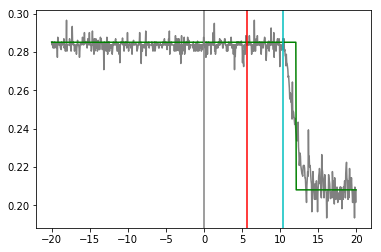

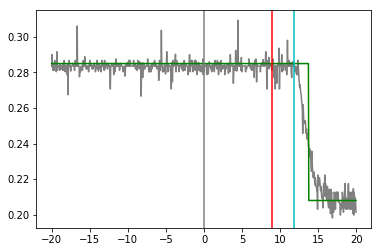

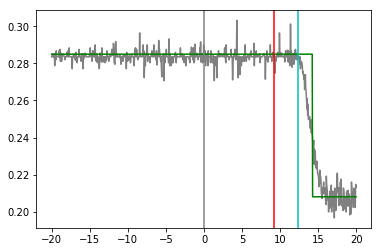

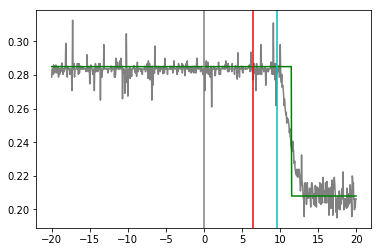

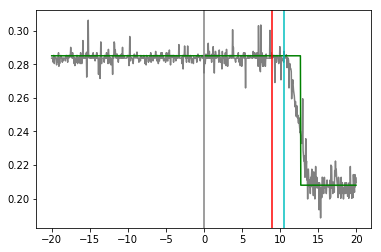

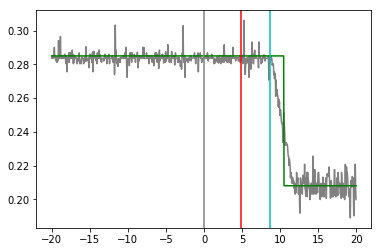

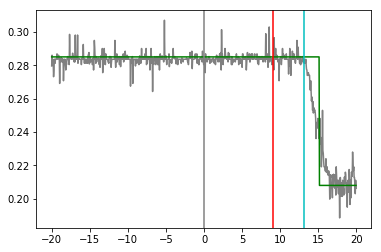

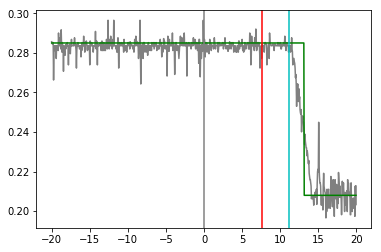

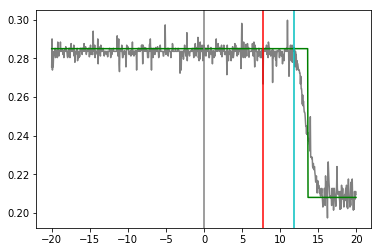

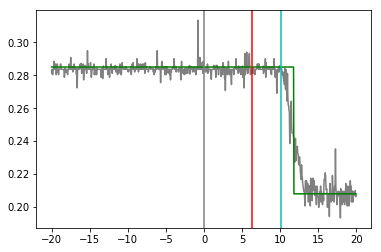

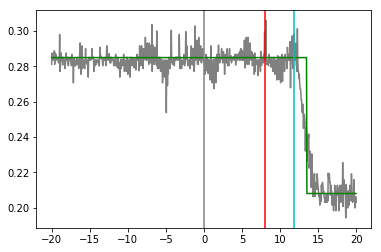

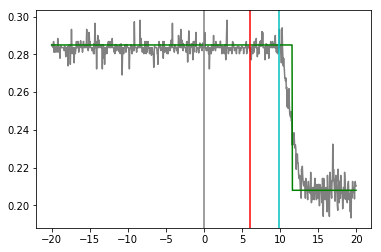

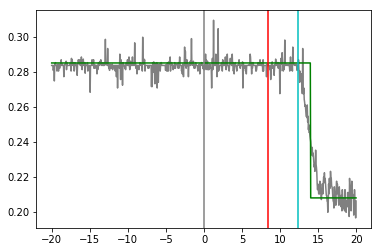

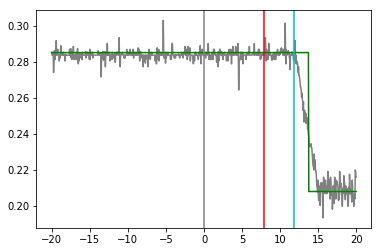

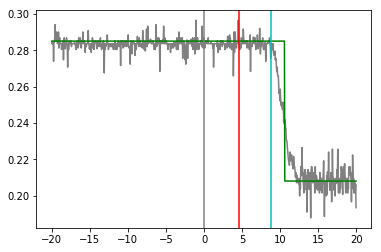

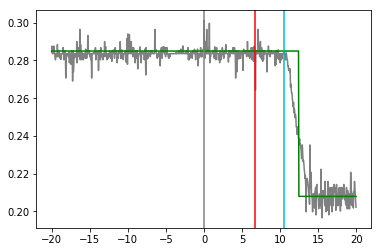

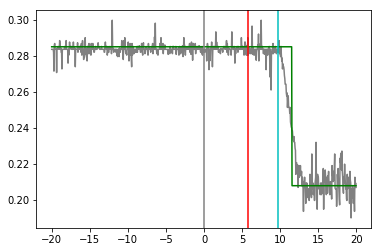

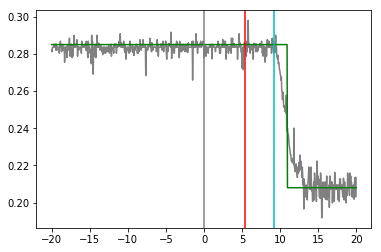

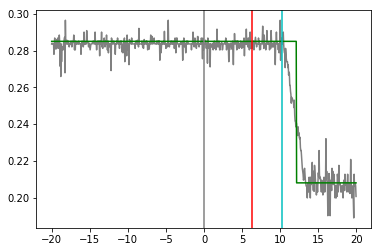

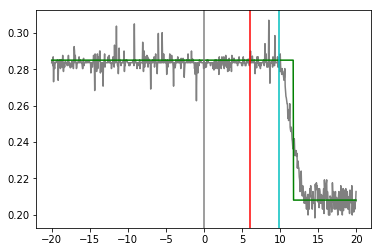

In [36]:
transWindowToLook = 20
stimCounter = 0
for tagTime in downTransitionBeforeStimFlipTag:
    plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            photoDiodeSig[int(tagTime-transWindowToLook*Fs/1e3):\
                       int(tagTime+transWindowToLook*Fs/1e3)],'gray')
    
    plt.plot(np.arange(-transWindowToLook,transWindowToLook,1e3/Fs),\
            digitizedFilteredSig[int(tagTime-transWindowToLook*Fs/1e3):\
                       int(tagTime+transWindowToLook*Fs/1e3)],'g')
    
    plt.axvline(0,c='gray')
    plt.axvline(estimatedTagDelay[stimCounter]*1e3 + 1e3/refR,c='c')
    plt.axvline(((downTransitionAfterStimFlipTag-downTransitionBeforeStimFlipTag)*1e3/Fs)[stimCounter],c='r')
    
    stimCounter += 1

### Consistency of the defined stim start relative to the estimated start time (cyan line in the above figs) 

In [37]:
estimatedStartTime = downTransitionBeforeStimFlipTag*1e3/Fs + np.array(estimatedTagDelay)*1e3 + 1e3/refR
photoDiodeDefinedStartTime = stimOnset*1e3/Fs

In [38]:
photoDiodeDefinedStartTime - estimatedStartTime

array([1.74874112, 1.90494112, 1.84207778, 1.9063793 , 2.09296335,
       1.81795911, 1.95590144, 1.88556245, 1.75018387, 1.71035261,
       1.64938082, 1.69501099, 1.67328276, 1.91109812, 1.75337853,
       1.8419119 , 1.75459773, 1.71721726, 1.83614979, 1.82576648])

In [39]:
print(np.mean(photoDiodeDefinedStartTime - estimatedStartTime))
print(np.std(photoDiodeDefinedStartTime - estimatedStartTime))

1.8136428254847374
0.10682306257164745


In [54]:
(frameNumber*1.0/refR)*1e3

27.777777777777775

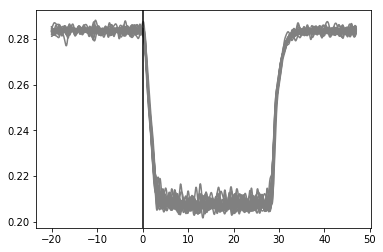

In [56]:
transWindowToLook = 20
stimDur = int((frameNumber*1.0/refR)*1e3)
for tagTimeCorrected in estimatedStartTime*Fs/1e3:
#     plt.figure()
    plt.plot(np.arange(-transWindowToLook,transWindowToLook+stimDur,1e3/Fs),\
            filteredPhotoDiodeSig[int(tagTimeCorrected-transWindowToLook*Fs/1e3):\
                       int(tagTimeCorrected+(transWindowToLook+stimDur)*Fs/1e3)],'gray')
    
plt.axvline(0,c='k')

## Conclusion

### Matlab code used for generating data in this test